In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import svgpathtools
from svgpathtools import Line, Path, svg2paths, wsvg, disvg
import numpy as np
import matplotlib.pyplot as plt
import math
import cvxpy as cp
import scipy
import scipy.ndimage
from track import Track
from tire import fiala_tire_model, fiala_lookup

plt.style.use('seaborn')

# Parameters

In [188]:
SVG_OFFSET = (-10.0, 10.0)

# SEGMENT_LENGTH = 0.05  # in meters
SEGMENT_LENGTH = 0.05
BOUNDARY_SEGMENT_LENGTH = 0.01 # in meters, finer 
TRACK_WIDTH = 1.3
ROBOT_HALF_WIDTH = 0.2 # includes safety padding
G = 9.807

ROBOT_MASS = 1.457 # kg
ROBOT_LF = 0.128
ROBOT_LR = 0.137
ROBOT_I = 0.0965

MIU = 1.2
F_MIU = 1.05

TOP_SPEED = 9.5

MAX_ACCEL = MIU*G

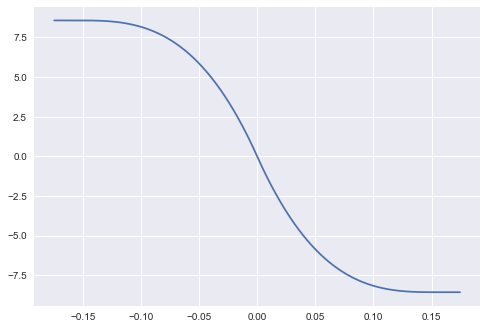

In [12]:
Fz = ROBOT_MASS*G/2
C = MIU*Fz / np.radians(3)  # semi nonsense value.
alpha, force = fiala_tire_model(Fz, MIU, C)

plt.figure()
plt.plot(alpha, force)
plt.show()

# Create Initial Offset Sketch

In [38]:
# construct offset curves for track boundaries

paths, attrs = svg2paths(r'd:\tmp\car\0219\drawing.svg')
path = paths[0]

def offset_curve(path, offset_distance, steps=1000):
    """Takes in a Path object, `path`, and a distance,
    `offset_distance`, and outputs an piecewise-linear approximation 
    of the 'parallel' offset curve."""
    nls = []
    for seg in path:
        for k in range(steps):
            t = k / steps
            offset_vector = offset_distance * seg.normal(t)
            nl = Line(seg.point(t), seg.point(t) + offset_vector)
            nls.append(nl)
    connect_the_dots = [Line(nls[k].end, nls[k+1].end) for k in range(len(nls)-1)]
    if path.isclosed():
        connect_the_dots.append(Line(nls[-1].end, nls[0].end))
    offset_path = Path(*connect_the_dots)
    return offset_path

left_boundary = offset_curve(path, 650.0, steps=5)
right_boundary = offset_curve(path, -650.0, steps=5)

disvg([path, left_boundary, right_boundary], 'brg', filename=r'd:\tmp\car\test_boundaries.svg')


FileNotFoundError: [Errno 2] No such file or directory: 'd:\\tmp\\car\\0219\\drawing.svg'

# Load Final Track Model

Racing path length is  48.10618601736664


c:\projects\zoomies\venv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[0][962]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
c:\projects\zoomies\venv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[1][962]=x[1][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %


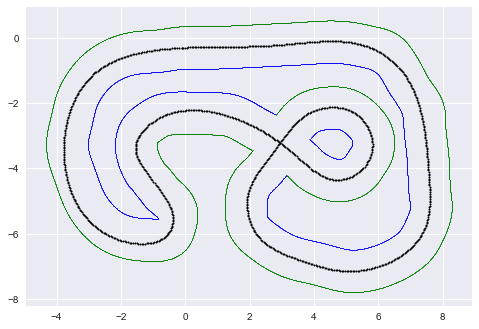

In [189]:
paths, attrs = svg2paths(r'C:\projects\zoomies\data\map\map.svg')
racing_path = paths[0]
left_boundary = paths[1]
right_boundary = paths[2]

print("Racing path length is ", racing_path.length() / 1000)

def make_pts(path, segment_length):
  L = path.length()
  steps = int(L / (segment_length * 1000))
  tpts = [path.ilength(L*k/steps) for k in range(steps)]
  pts = [path.point(t) / 1000 for t in tpts]
  # SVG y-axis is reversed
  return [[p.real + SVG_OFFSET[0] for p in pts], [-p.imag + SVG_OFFSET[1] for p in pts]]

track = Track()
track.racing_line_from_points(make_pts(racing_path, SEGMENT_LENGTH), smooth_factor=1)
track.set_left_boundary(make_pts(left_boundary, BOUNDARY_SEGMENT_LENGTH))
track.set_right_boundary(make_pts(right_boundary, BOUNDARY_SEGMENT_LENGTH))

track.display()

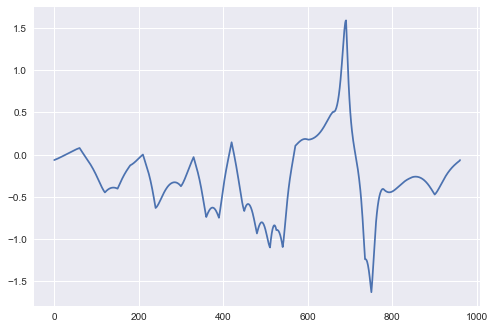

In [8]:
plt.figure()
plt.plot([*range(len(track.K))], track.K)
plt.show()

# Optimize

## Velocity

status: optimal_inaccurate
optimal value 9.406619796641522


c:\projects\zoomies\venv\lib\site-packages\cvxpy\problems\problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


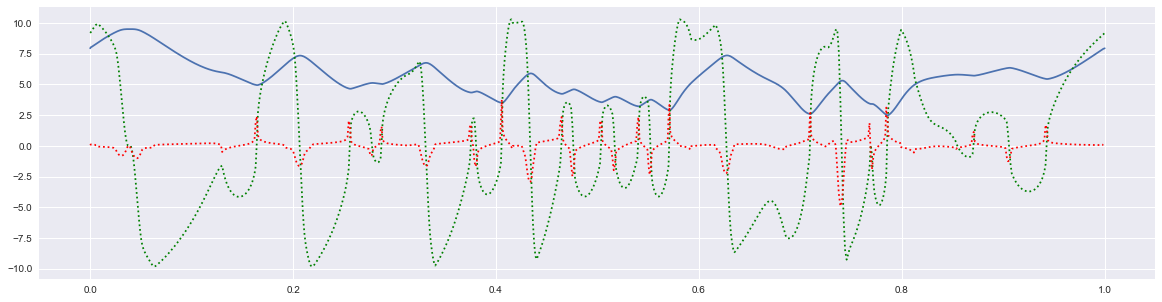

In [200]:
def v_opt():
    N = len(track.K)
    B = cp.Variable(N)    # V_x^2
    A = cp.Variable(N)    # a_x
    Fx = cp.Variable(N)
    Fy = cp.Variable(N)

    constraints = [
        cp.diff(B) == cp.multiply(cp.multiply(2, track.S[:-1]), A[:-1]),
        A[0] == A[-1],
        B[0] == B[-1],
        B <= TOP_SPEED**2,
        cp.square(Fy) + cp.square(cp.multiply(MIU / F_MIU, Fx)) <= (ROBOT_MASS * MIU * G)**2,
        Fx == cp.multiply(ROBOT_MASS, A),
        Fy == cp.multiply(cp.multiply(ROBOT_MASS, track.K), B),
    ]

    obj = cp.Minimize(cp.sum(cp.multiply(track.S, cp.power(B, -0.5))) + 6e-8*cp.sum_squares(cp.diff(A)/track.S[:-1]))
    # obj = cp.Minimize(cp.sum(cp.multiply(track.S, cp.power(B, -0.5))))

    prob = cp.Problem(obj, constraints)
    prob.solve()

    print("status:", prob.status)
    print("optimal value", prob.value)

    return [math.sqrt(x.value) for x in B], [a.value for a in A]

V, A = v_opt()

plt.figure(figsize=(20,5))
plt.plot(track.u, V, '-')
plt.plot(track.u[0:], A, ':g')
plt.plot(track.u[0:-1], np.diff(A), ':r')
plt.show()

In [195]:
# Crude laptime estimate
np.sum(np.array(track.S) / np.array(V))

9.411076064069604

## Path

In [192]:
def c2d(dt, A, B, D):
  ar, ac = A.shape
  assert B.shape == (ar,1)
  assert D.shape == (ar,1)
  X = dt * np.concatenate((A, B, D), axis=1)
  r, c = X.shape
  X = np.concatenate((X, np.zeros((c-r, c))))
  Xt = scipy.linalg.expm(X)

  return Xt[0:ar,0:ac], Xt[0:ar,ac], Xt[0:ar,ac+1]


left_dists, right_dists = track.boundary_dist(ROBOT_HALF_WIDTH)
left_dists.append(left_dists[0])
right_dists.append(right_dists[0])

N = len(V)+1
x = cp.Variable((5, N)) # [e delta_heading yaw_rate beta heading]
# slack = cp.Variable(5)
delta = cp.Variable(N)
constraints = [
  x[0,0] == 0,
  x[0,:] <= left_dists,
  -1.0*x[0,:] <= right_dists,
  cp.abs(x[0:4,0] - x[0:4,-1]) <= 0.0001,
]

for idx in range(N-1):
  s = track.S[idx]
  dt = s/V[idx]
  A = np.zeros((5, 5), dtype=np.float64)
  # assumes even weight dstro.. should fix?
  Fyf = ROBOT_MASS/2*track.K[idx]*V[idx]**2
  Fyr = Fyf
  slip_front, Cf = fiala_lookup(alpha, force, Fyf)
  slip_rear, Cr = fiala_lookup(alpha, force, Fyr)
  A[0,1] = V[idx]
  A[0,3] = V[idx]
  A[1,2] = 1.0
  A[2,2] = (-(ROBOT_LF**2)*Cf-(ROBOT_LR**2)*Cr)/(V[idx]*ROBOT_I)
  A[2,3] = (ROBOT_LR*Cr-ROBOT_LF*Cf)/ROBOT_I
  A[3,2] = (ROBOT_LR*Cr-ROBOT_LF*Cf)/(ROBOT_MASS*V[idx]**2) - 1
  A[3,3] = (-Cf-Cr)/(ROBOT_MASS*V[idx])
  A[4,2] = 1.0
  B = np.array([0.0, 0.0, ROBOT_LF * Cf / ROBOT_I, Cf / (ROBOT_MASS * V[idx]), 0]).reshape((5,1))
  D = np.array([
    0.0,
    -track.K[idx]*V[idx],
    (ROBOT_LF*Cf*slip_front - ROBOT_LR*Cr*slip_rear + ROBOT_LF*Fyf - ROBOT_LR*Fyr)/ROBOT_I,
    (Cf*slip_front + Cr*slip_rear + Fyf + Fyr)/(ROBOT_MASS*V[idx]),
    0.0
  ]).reshape((5,1))
  Ak, Bk, Dk = c2d(dt, A,B,D)
  constraints.append(x[:,idx+1] == Ak@x[:,idx] + Bk*delta[idx] + Dk)

# obj = cp.Minimize(cp.sum_squares(cp.diff(x[4,:])/np.diff(S)) + 0.01*cp.sum_squares(cp.diff(delta)) + 500000*cp.norm(slack, p=2))
obj = cp.Minimize(cp.sum_squares(cp.diff(x[4,:])/np.roll(track.S,-1)) + 1.0*cp.sum_squares(cp.diff(delta)))

prob = cp.Problem(obj, constraints)
prob.solve()

print("status:", prob.status)
print("optimal value", prob.value)

status: optimal
optimal value 176.88171022570546


c:\projects\zoomies\venv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[0][962]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
c:\projects\zoomies\venv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[1][962]=x[1][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %


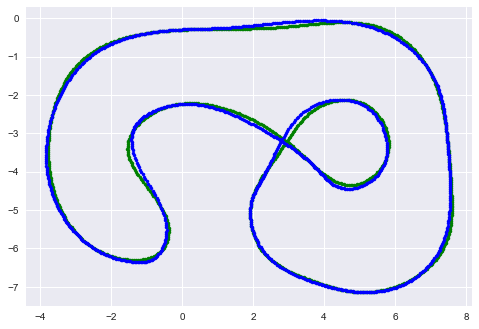

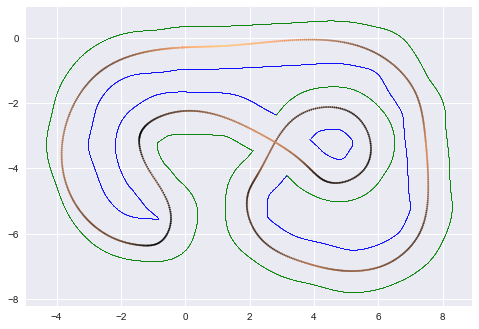

In [193]:
plt.figure()
plt.plot(track.pts[0], track.pts[1],'.g')

new_x = []
new_y = []
for idx in range(len(track.pts[0])):
  xp, yp = track.pts[0][idx], track.pts[1][idx]
  xstar = x.value[:,idx]
  new_x.append(xp - xstar[0]*math.cos(xstar[4]))
  new_y.append(yp - xstar[0]*math.sin(xstar[4]))

track.racing_line_from_points([new_x, new_y], smooth_factor=0.1)
plt.plot(track.pts[0], track.pts[1],'.b')

plt.show()

track.display(V)

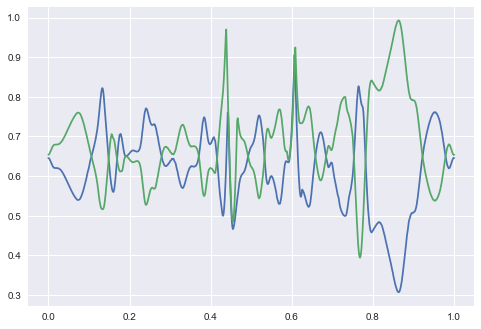

In [13]:
ld, rd = track.boundary_dist(0)
plt.figure()
plt.plot(track.u, ld, track.u, rd)
plt.show()

In [56]:
N = len(track.pts[0])

from collections import namedtuple
PathPoint = namedtuple('PathPoint', ['s', 'heading', 'velocity', 'x', 'y'])
rp = []

pxy = (0,0)
total_s = 0.0
for i in range(N):
  xy = (track.pts[0][i], track.pts[1][i])
  v = V[i]
  heading = 0
  if i > 0:
    heading = math.atan2(xy[1] - pxy[1], xy[0] - pxy[0])

  pxy = xy
  pp = PathPoint(total_s, heading, v, xy[0], xy[1])
  total_s += track.S[i]
  rp.append(pp)

import serde

serde.write(r'd:\tmp\car\0902\path_1_05_1_2.bin', np.average(track.S), MAX_ACCEL, rp)


In [60]:
np.average(track.S)

0.04982300338673329

In [202]:
np.max(np.abs(track.K))

1.9015347664489133